In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 9.89732184e+02, -1.19746289e+02, -1.97409429e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 9.89768499e+02, -1.19735860e+02, -1.97410766e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 9.89681805e+02, -1.19738573e+02, -1.97401416e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 9.89936113e+02, -1.19777279e+02, -1.97450172e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 9.89917252e+02, -1.19778816e+02, -1.97441199e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 9.89954919e+02, -1.19774158e+02, -1.97441629e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:02<00:00, 25.15it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 2
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:01<00:00, 23636.12it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    closses=0
    flosses=0
    elosses=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # reshape decoded_x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        # decoded_x = decoded_x.reshape(batch_size, n_neigh+1, 3)
        # reshape data.x as N P D dimensions where N is batch size, P is number of points and D is dimension of each point
        # data.x = data.x.reshape(batch_size, n_neigh+1, 3)
        # calculate chamfer distance between decoded_x and data.x
        # print(decoded_x.shape,data.x.shape)
        # print(decoded_x.device,data.x.device)
        # print(decoded_x.dtype,data.x.dtype)
        # print(decoded_x.requires_grad,data.x.requires_grad)
        # closs=chamfer_distance(decoded_x,data.x)
        # closs=closs[0]
        # loss=closs

        floss=MSE_loss(decoded_x, data.x)
      
        loss=floss
        loss.backward()
        all_loss_mse += float(loss)
      
        # flosses+=float(floss)
        optimizer.step()
        
    return all_loss_mse/len(train_loader)
   

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []
closses=[]
flosses=[]
elosses=[]
if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 143499.2580
	Test: 	MSE Loss: 134144.1201
Epoch: 002
	Train:	MSE Loss: 67026.3343
	Test: 	MSE Loss: 52866.8044


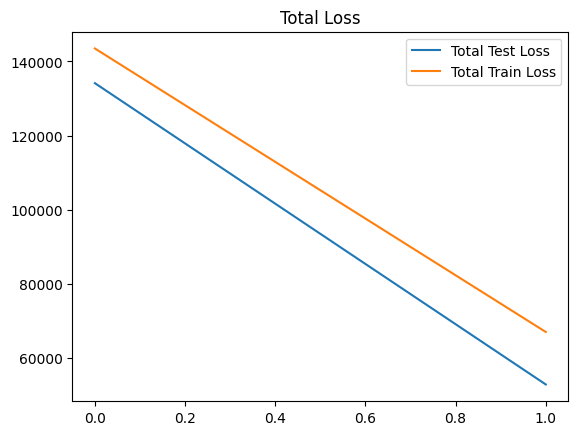

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

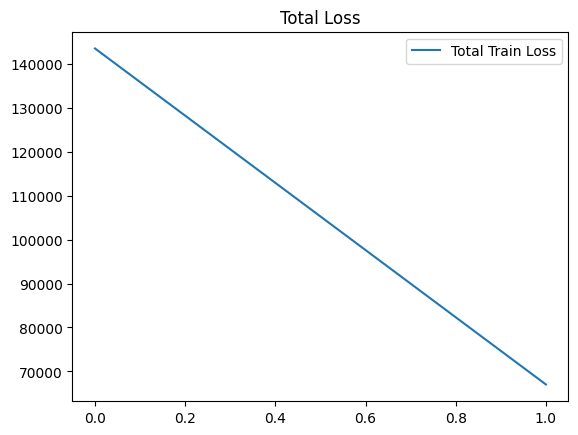

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

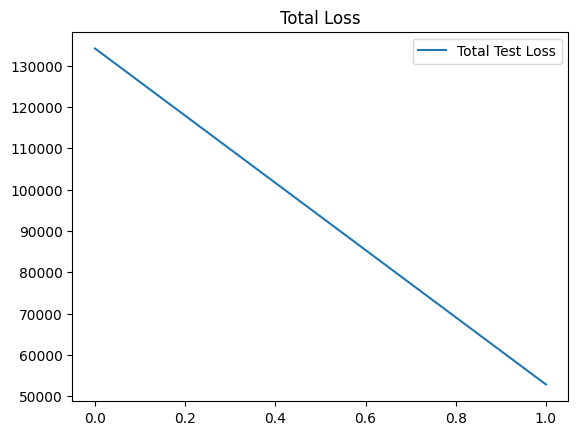

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 52681.08589340808


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

20

In [26]:
decoded_feature[0][heavy_indices]

tensor([[1142.8286,  -17.2078,  -17.8294,   16.1014,   16.2642,   16.6373],
        [ 530.8450,   -7.9695,   -8.2648,    9.5175,    9.9175,    9.0756],
        [ 445.0999,   -6.6795,   -6.9301,    8.5038,    8.8624,    7.8858],
        [ 444.9921,   -6.6779,   -6.9285,    8.5025,    8.8611,    7.8842],
        [ 505.8984,   -7.5939,   -7.8762,    9.2325,    9.6252,    8.7403],
        [ 455.4377,   -6.8350,   -7.0910,    8.6292,    8.9939,    8.0319],
        [ 445.1515,   -6.6803,   -6.9309,    8.5044,    8.8631,    7.8865],
        [ 500.7222,   -7.5161,   -7.7956,    9.1715,    9.5615,    8.6683],
        [ 525.7295,   -7.8923,   -8.1848,    9.4638,    9.8653,    9.0132],
        [ 499.4924,   -7.4976,   -7.7765,    9.1570,    9.5464,    8.6512],
        [ 452.5703,   -6.7918,   -7.0464,    8.5945,    8.9574,    7.9914],
        [ 483.1780,   -7.2522,   -7.5226,    8.9640,    9.3444,    8.4234],
        [ 445.0573,   -6.6788,   -6.9295,    8.5033,    8.8619,    7.8852],
        [ 44

In [27]:
input_feature[0][heavy_indices]

tensor([[ 989.0982, -119.5376, -197.2758,   21.0850,    5.1650,   18.4925],
        [ 988.8902, -119.5221, -197.1269,   22.1875,    6.9400,   16.8825],
        [ 989.7432, -119.7284, -197.3441,   19.8975,    2.7000,   18.4900],
        [ 988.0980, -119.4480, -197.0893,   19.2675,    7.1675,   17.7000],
        [ 988.6635, -119.5132, -197.3306,   23.5400,    5.5575,   19.9125],
        [ 989.1815, -119.7847, -197.2841,   22.8125,    4.5325,   15.9750],
        [ 990.0782, -119.8298, -197.4501,   21.3425,    2.2850,   20.8625],
        [ 989.4370, -119.7509, -197.3046,   22.4375,    4.5725,   22.0325],
        [ 989.1665, -119.6942, -197.3719,   23.1350,    1.9000,   18.7625],
        [ 987.8921, -119.3707, -196.9756,   16.9800,    3.2675,   18.6075],
        [ 988.2183, -119.4934, -197.2343,   19.6175,    5.0550,   14.0850],
        [ 988.2039, -119.4090, -197.1066,   20.1850,    7.7500,   14.6825],
        [ 987.6699, -119.4430, -197.0909,   19.2550,    4.2275,   22.7225],
        [ 98

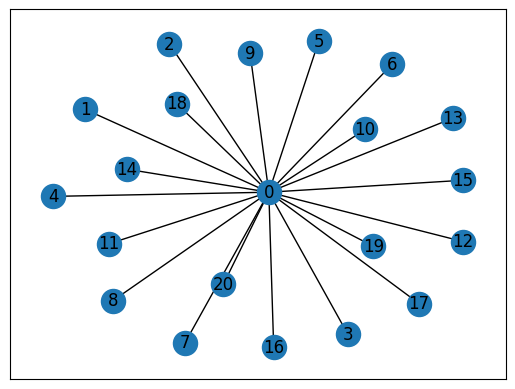

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()


In [29]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()
from pytorch3d.loss import chamfer_distance
def tryshape():
    m=0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        # chamfer_distance needs shaped N P D
        # N is number of points
        # P is number of points to compare to
        # D is dimension of each point
        # where N is the number of points in the pointcloud = 4*number of atoms
        # P is the number of points to compare to = 4*number of atoms
        # D is the dimension of each point = 3
        # reshape decoded_x
        # print(decoded_x.shape) - [672,6]
        decoded_x = decoded_x.reshape(21,32,6)
        data.x=data.x.reshape(21,32,6)
        closs=chamfer_distance(decoded_x,data.x)
        closs=closs[0]
        loss=closs
        loss.backward()
        all_loss_mse += float(loss)
        # flosses+=float(floss)
        optimizer.step()

        if(m==0):
            # print(data.x)
            print(decoded_x)
            print(f"Data.shape : {data.x.shape}")
            print(f"Decoded.shape : {decoded_x.shape}")
            print(f"Data[0].shape : {data[0].x.shape}")
            print(f"Data[1].shape : {data[1].x.shape}")
            print(f"Data[2].shape : {data[2].x.shape}")
            print(f"Data[3].shape : {data[3].x.shape}")
            print(f"Data[4].shape : {data[4].x.shape}")
            print(f"Data[5].shape : {data[5].x.shape}")
            print(f"Data[6].shape : {data[6].x.shape}")
            print(f"Data[7].shape : {data[7].x.shape}")
            print(f"Data[8].shape : {data[8].x.shape}")
            print(f"Data[21].shape : {data[21].x.shape}")
            
            print(f"Decoded[0].shape : {decoded_x[0].shape}")
        m+=1
    return all_loss_mse/len(train_loader)
    # return all_loss_mse/len(train_loader),closses/len(train_loader),flosses/len(train_loader),elosses/len(train_loader)

In [32]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs*10 + 1):

        # train_loss_mse,closs,floss,eloss = train()
        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        # print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f},\tChamfer Loss: {closs:.4f},\tEdge Loss: {eloss:.4f},\tFace Loss: {floss:.4f}')
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 51.6195
Epoch: 002
	Train:	MSE Loss: 38.8952


KeyboardInterrupt: 

In [ ]:
tryshape()


tensor([[2118.1438,  -22.5189,  -28.6591,   27.3942,   28.4206,   26.3208],
        [ 745.9501,   -7.9290,  -10.0930,   10.4336,   10.4813,   10.2565],
        [ 699.0690,   -7.4305,   -9.4587,    9.8556,    9.8704,    9.7103],
        ...,
        [ 833.4938,   -8.8598,  -11.2774,   11.5127,   11.6221,   11.2765],
        [ 844.5501,   -8.9774,  -11.4270,   11.6490,   11.7662,   11.4053],
        [ 928.1469,   -9.8662,  -12.5581,   12.6795,   12.8555,   12.3793]],
       device='cuda:0', dtype=torch.float64, grad_fn=<LeakyReluBackward0>)
Data.shape : torch.Size([672, 6])
Decoded.shape : torch.Size([672, 6])
Data[0].shape : torch.Size([21, 6])
Data[1].shape : torch.Size([21, 6])
Data[2].shape : torch.Size([21, 6])
Data[3].shape : torch.Size([21, 6])
Data[4].shape : torch.Size([21, 6])
Data[5].shape : torch.Size([21, 6])
Data[6].shape : torch.Size([21, 6])
Data[7].shape : torch.Size([21, 6])
Data[8].shape : torch.Size([21, 6])
Data[21].shape : torch.Size([21, 6])
Decoded[0].shape : torc

1